In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
np.set_printoptions(precision=3)
from qiskit.providers.aer.noise import NoiseModel


In [2]:
%run groverFuncs.py
%run bipartiteGraphFuncs.py
%run completeGraphFuncs.py
%run IBMTools.py
%run qaoaFuncs.py

# Grover Search
This file contains the implementation of the Grover Search problem and variations of the algorithm applied to different data structures (quantum walks) and using a different method (QAOA). 

We start out by importing the files containing the functions that will be used to construct the circuits.

The aproach was to create an oracle and a diffusion operator by implementing their respective diagonal matrices and subsequently use qiskit to create an equivalent circuit. We then append the oracle and diffusion operators to the specific data structure in the overarching search function. The only exception to this is the QAOA algorithm, that requires a different methodology due to the nature of the algorithm.

## Generalized Grover
In this section we implement the generalized version of the grover algorith.  
The **oracle** has the following effect in a generic state

<img src="Images/oracleGrover.png" />

And it corresponds to the following diagonal matrix if we were to search for state |1> in an N=2 qubit system 

In [25]:
print(getOracle([1],2))

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


The **diffusion operator** is given by

<img src="Images/diffGrover.png"/>

where |$\psi$> is the balanced superposition of the system's states.  
The matrix corresponding to this operator is 

In [26]:
print(simulUnitary(diffusionGrover(2)))

[[ 0.5-1.225e-16j -0.5+1.225e-16j -0.5+1.225e-16j -0.5+1.225e-16j]
 [-0.5+6.123e-17j  0.5-1.837e-16j -0.5+6.123e-17j -0.5+1.837e-16j]
 [-0.5+6.123e-17j -0.5+6.123e-17j  0.5-1.837e-16j -0.5+1.837e-16j]
 [-0.5+0.000e+00j -0.5+1.225e-16j -0.5+1.225e-16j  0.5-2.449e-16j]]


The entire circuit will then be the successive application of both of these operators.  
The circuit after one step is then

<img src="Images/Grover.png" alt="Drawing" style="width: 700px;" />


## Grover Search in a Complete Graph

Implementing the Grover Search in a Complete Graph relies on the fact that the "classical" Grover's algorithm is equivalent to searching a Complete Graph with loops, as was shown in Renato Portugal's book "Quantum Walks and Search Algorithms".  

The first step in this implementation was noticing that the shift operator is defined as

<img src="Images/shiftRenato.png"/>

Inspired by B. L. Dougas and J. B. Wang's article "Efficient quantum circuit implementation of quantum walks" we placed a series of swap gates between the register qubits (vertices) and the coin.   
The coin operator will be given by

<img src="Images/coinCompleteRenato.png"/>

Where G is the diffusion operator defined above.  
The oracle operator will be the same as the Grover Algorithm, applied only to the vertices.

The entire circuit will be

<img src="Images/Complete.png" alt="Drawing" style="width: 700px;" />



Note that the function allows for an arbitrary number of vertices and coin states as well as the ability to mark any number of elements, at the cost of a bigger circuit size which means more error outside of the simulator.

## Bipartite Graph

Searching through a bipartite graph is very similar to the complete graph case, the difference being the structure of the graph

<img src="Images/bipartitegraph.png" alt="Drawing" style="width: 250px;"/>

We can tell from the image that this graph can be viewed as a complete graph (all edges connected) where each vertex had one edge removed.  
Translating into a circuit, this corresponds to removing one qubit of the coin operator and replacing the swap of the most significant qubit with an X gate

<img src="Images/Bipartite.png" alt="Drawing" style="width: 700px;" />


## Results

### QASM

In [13]:
N = 4
n = N-1

qcG = grover2([1],N,2)
qcC = runWalkComplete2([1],N,3)
qcB = runWalkBipartite2([1],N,n,4)

gQasm = simul(qcG)
cQasm = simul(qcC)
bQasm = simul(qcB)

print("Grover size: ", qcG.size())
print("Complete size: ",qcC.size())
print("Bipartite size: ",qcB.size())


Grover size:  12
Complete size:  187
Bipartite size:  20


In [14]:
#plot_histogram(gQasm)

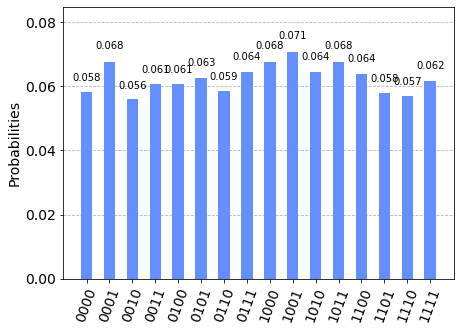

In [15]:
plot_histogram(cQasm)

In [8]:
# plot_histogram(bQasm)

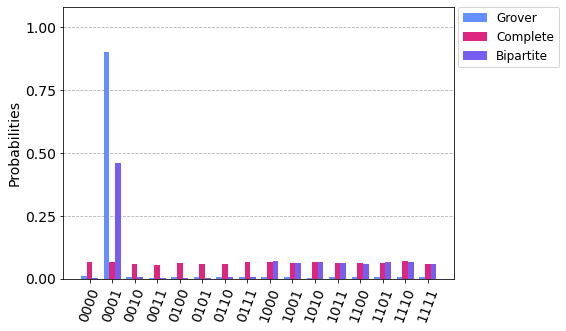

In [34]:
plot_histogram([gQasm,cQasm,bQasm],legend=['Grover', 'Complete','Bipartite'],bar_labels=False)

In [107]:
angle = ((np.pi)/3)
gamma = np.pi
qaoaSimul = runQAOA(3,angle,0,np.pi,1)


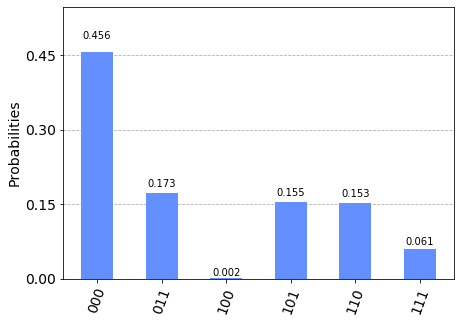

In [109]:
plot_histogram(simul(qaoaSimul))

### IMBQ

In [3]:
provider = setProvider('ibm-q-minho','academicprojects','quantalab')
leastBusyBackend = leastBusy(10,provider)
print("Least busy backend:",leastBusyBackend)


Least busy backend: ibmq_16_melbourne


In [4]:
torontoBackend = provider.get_backend('ibmq_toronto')
melBackend = provider.get_backend('ibmq_16_melbourne')
cambBackend = provider.get_backend('ibmq_cambridge')
rochBackend = provider.get_backend('ibmq_rochester')
bogBackend = provider.get_backend('ibmq_bogota')
joanBackend = provider.get_backend('ibmq_johannesburg')

In [24]:
print("Available Backends:")
print(listBackends(provider))
print()


Available Backends:
ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_london
ibmq_burlington
ibmq_johannesburg
ibmq_rochester
ibmq_essex
ibmq_armonk
ibmq_cambridge
ibmq_paris
ibmq_rome
ibmq_toronto
ibmq_bogota
None



Adapting QASM simulator to a specific backend

In [178]:
deviceBackend = joanBackend
basisGatesD = deviceBackend.configuration().basis_gates

In [122]:
noiseModel = NoiseModel.from_backend(deviceBackend)
basisGates = noiseModel.basis_gates
# print(noiseModel)

In [202]:
couplingMap = deviceBackend.configuration().coupling_map
initLayout = [11,10,5,12,7,6]

In [124]:
simulator = Aer.get_backend('qasm_simulator')

In [174]:
%run groverFuncs.py
%run bipartiteGraphFuncs.py
%run completeGraphFuncs
%run IBMTools.py
%run qaoaFuncs.py

ibmqfactory.load_account:WARNING:2020-07-29 04:27:37,892: Credentials are already in use. The existing account in the session will be replaced.


In [205]:
N2 = 3
n2 = N2-1
qcGNoise = grover2([0],N2,1)
# print("%d depth, %d CNOTs" % (qcGNoise.depth(), qcGNoise.count_ops().get('cx')))
# qcGNoise = transpile(qcGNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=15)
# print("%d depth, %d CNOTs" % (qcGNoise.depth(), qcGNoise.
# count_ops().get('cx')))
# print(qcGNoise.count_ops())
circuitsG =  transpile(qcGNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=15)


In [206]:
qcCNoise = runWalkComplete2([0],N2,2)
print("%d depth, %d CNOTs" % (qcCNoise.depth(), qcCNoise.count_ops()['cx']))
# qcCNoise = transpile(qcCNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,initial_layout=initLayout,seed_transpiler=8)
print("%d depth, %d CNOTs" % (qcCNoise.depth(), qcCNoise.count_ops()['cx']))
circuitsC = transpile(qcCNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,initial_layout=initLayout,seed_transpiler=8)
# circuitsC = transpile(qcCNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=8)
# print("%d depth, %d CNOTs" % (circuitsC.depth(), circuitsC.count_ops()['cx']))


31 depth, 42 CNOTs
44 depth, 68 CNOTs


In [214]:
qcBNoise = runWalkBipartite2([0],N2,n2,2)
# qcBNoise = transpile(qcBNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=0)
# print("%d depth, %d CNOTs" % (qcBNoise.depth(), qcBNoise.count_ops()['cx']))
circuitsB = transpile(qcBNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,initial_layout=initLayout,seed_transpiler=0)
# circuitsB = transpile(qcBNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=0)
print("%d depth, %d CNOTs" % (circuitsB.depth(), circuitsB.count_ops()['cx']))

57 depth, 52 CNOTs


In [218]:
qaoaNoise = runQAOA(N2,angle,0,gamma,1)
circuitsQAOA = transpile(qaoaNoise,basis_gates=basisGatesD,backend=deviceBackend,optimization_level=3,layout_method='noise_adaptive',seed_transpiler=22)
# qaoaNoise.draw(output='mpl')

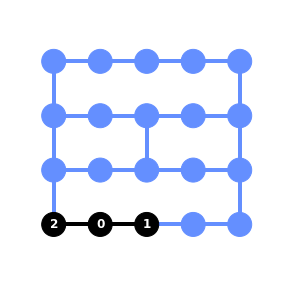

In [219]:
plot_circuit_layout(circuitsQAOA,deviceBackend)
# plot_gate_map(deviceBackend)

In [215]:
# printBestSeed(circuitsB,basisGatesD,deviceBackend,0,30)

(0, 52)
(0, 57)


In [220]:
resultNoiseG = execute(circsG,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoiseG = resultNoiseG.get_counts(circuitsG)
# plot_histogram(countsNoiseG)

QiskitError: 'Data for experiment "circuit52149" could not be found.'

In [ ]:
resultNoiseC = execute(circuitsC,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoiseC = resultNoiseC.get_counts(circuitsC)
# plot_histogram(countsNoiseC)

In [ ]:
resultNoiseB = execute(circuitsB,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoiseB = resultNoiseB.get_counts(circuitsB)
# plot_histogram(countsNoiseB)

In [223]:
resultNoiseQAOA = execute(circuitsQAOA,simulator,noise_model=noiseModel,coupling_map=couplingMap,basis_gates=basisGates).result()
countsNoiseQAOA= resultNoiseQAOA.get_counts(circuitsQAOA)
# plot_histogram(countsNoiseQAOA)

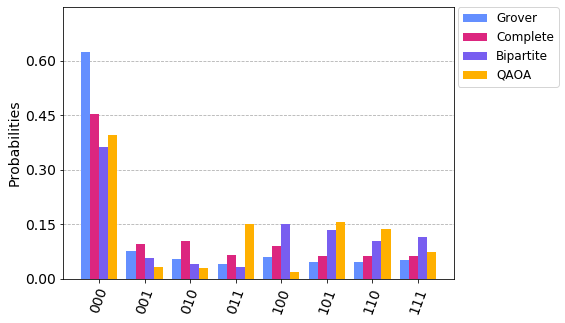

In [224]:
plot_histogram([countsNoiseG,countsNoiseC,countsNoiseB,countsNoiseQAOA],legend=['Grover', 'Complete','Bipartite','QAOA'],bar_labels=False)

Running on a real device

In [225]:
resultGrover5 = run(circsG,deviceBackend,shots=8000)
resultComplete5 = run(circuitsC, deviceBackend,shots=8000)
resultBipartite5 = run(circuitsB,deviceBackend,shots=8000)
resultQAOA = run(circuitsQAOA,deviceBackend,shots=8000)

In [226]:
countsGrover5 = getJobCounts(resultGrover5,deviceBackend)
countsComplete5 = getJobCounts(resultComplete5,deviceBackend)
countsBipartite5 = getJobCounts(resultBipartite5,deviceBackend)
resultQAOA5 = getJobCounts(resultQAOA,deviceBackend)

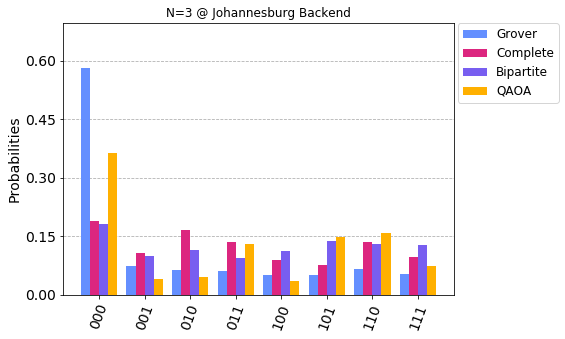

In [227]:
plot_histogram([countsGrover5,countsComplete5,countsBipartite5,resultQAOA5],legend=['Grover', 'Complete','Bipartite','QAOA'],bar_labels=False,title='N=3 @ Johannesburg Backend')

In [324]:
# countsGrover4 = getJob('5f1def584464cc001b7da5de',provider,leastBusyBackend)
# countsComplete4 = getJob('5f1def563d07a00015d614d0',provider,leastBusyBackend)
# countsBipartite4 = getJob('5f1def53bb1ebb0013c647d5',provider,leastBusyBackend)

In [95]:
# plot_histogram([countsGrover4,countsComplete4,countsBipartite4],legend=['Grover', 'Complete','Bipartite'],bar_labels=False)